In [1]:
import os, sys
%env LD_LIBRARY_PATH=/usr/local/cuda-8.0/lib64
%env LIBRARY_PATH=/usr/local/cuda-8.0/lib64
%env PATH=/usr/local/cuda-8.0/include:/usr/local/cuda-8.0/bin:/home/apanin/anaconda/bin:/opt/WinCC_OA/3.11/bin:/opt/pvss/pvss2_v3.8/bin:/home/apanin/anaconda/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/opt/fmc/bin:/group/online/bin:/group/online/scripts:/home/apanin/bin:/home/apanin/bin
sys.path.insert(0,"/home/apanin/rit_my/")
%env CUDA_VISIBLE_DEVICES=0
%env THEANO_FLAGS=device=cuda0,gpuarray.preallocate=0.99


env: LD_LIBRARY_PATH=/usr/local/cuda-8.0/lib64
env: LIBRARY_PATH=/usr/local/cuda-8.0/lib64
env: PATH=/usr/local/cuda-8.0/include:/usr/local/cuda-8.0/bin:/home/apanin/anaconda/bin:/opt/WinCC_OA/3.11/bin:/opt/pvss/pvss2_v3.8/bin:/home/apanin/anaconda/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/opt/fmc/bin:/group/online/bin:/group/online/scripts:/home/apanin/bin:/home/apanin/bin
env: CUDA_VISIBLE_DEVICES=0
env: THEANO_FLAGS=device=cuda0,gpuarray.preallocate=0.99


In [1]:
import os, sys
%env LD_LIBRARY_PATH=/usr/local/cuda-8.0
%env PATH=/home/apanin/anaconda/bin:/opt/WinCC_OA/3.11/bin:/opt/pvss/pvss2_v3.8/bin:/home/apanin/anaconda/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/opt/fmc/bin:/group/online/bin:/group/online/scripts:/home/apanin/bin:/home/apanin/bin
sys.path.insert(0,"/home/apanin/rit_my/")
%env CUDA_VISIBLE_DEVICES=0
%env THEANO_FLAGS=device=cuda0

env: LD_LIBRARY_PATH=/usr/local/cuda-8.0
env: PATH=/home/apanin/anaconda/bin:/opt/WinCC_OA/3.11/bin:/opt/pvss/pvss2_v3.8/bin:/home/apanin/anaconda/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/opt/fmc/bin:/group/online/bin:/group/online/scripts:/home/apanin/bin:/home/apanin/bin
env: CUDA_VISIBLE_DEVICES=0
env: THEANO_FLAGS=device=cuda0


In [2]:
import theano
import theano.tensor as T
import lasagne
import lasagne.layers as L

/home/apanin/anaconda/envs/py35/lib/python3.5/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Preallocating 11596/12207 Mb (0.950000) on cuda0
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:02:00.0)


## preprocess

In [ ]:
!./preprocess.sh data/indomain_training/indomain.de-en.de preprocessed/ en de
!./preprocess.sh data/indomain_training/indomain.de-en.en preprocessed/ de en

In [3]:
SRC_PATH = "preprocessed/indomain.de-en.de.bpe" 
DST_PATH = "preprocessed/indomain.de-en.en.bpe" 

In [4]:
raw_src = []
with open(SRC_PATH, 'r') as f:
    raw_src = f.readlines()
raw_dst = []
with open(DST_PATH, 'r') as f:
    raw_dst = f.readlines()

In [5]:
def fix_ends(sents):
    for i in range(len(sents)):
        sents[i] = sents[i][:-2]

In [6]:
fix_ends(raw_src)
fix_ends(raw_dst)

In [7]:
class Vocab:
    def __init__(self, sentences):
        tokens = set()
        for s in sentences:
            tokens.update(s.split(' '))
        self.tokens = ["__EOS__", "__BOS__", "__PAD__"] + list(tokens)
        self.EOS = 0
        self.BOS = 1
        self.PAD = 2
        self.len = len(self.tokens)
        self.token2id = {token: i for i, token in enumerate(self.tokens)}
    def tokenize(self, sentence):
        if not sentence.endswith("__EOS__"):
            sentence += " __EOS__"
        if not sentence.startswith("__BOS__"):
            sentence = "__BOS__ " + sentence
        return [self.token2id[token] for token in sentence.split(' ')]
    def detokenize(self, sentence):
        return " ".join([self.tokens[token] for token in sentence])
    def tokenize_many(self, sentences):
        return [self.tokenize(sent) for sent in sentences]
    def detokenize_many(self, sentences):
        return [self.dekenize(sent) for sent in sentences]

In [8]:
src_voc = Vocab(raw_src)
dst_voc = Vocab(raw_dst)

In [9]:
data = list(zip(src_voc.tokenize_many(raw_src), dst_voc.tokenize_many(raw_dst)))

In [10]:
src_voc.detokenize(data[14001][0]),dst_voc.detokenize(data[14001][1])

('__BOS__ &amp; Global settings .. __EOS__',
 '__BOS__ &amp; Globale Einstellungen .. __EOS__')

In [11]:
X = [x for x,y in data]
Y = [y for x,y in data]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, Y_train, Y_text = train_test_split(X,Y, test_size = 0.1, random_state = 42)

In [14]:
MAX_LEN = 100

In [15]:
from batch_iterator import iterate_minibatches

In [16]:
import numpy as np

In [17]:
np.random.seed(42)

In [18]:
%env KERAS_BACKEND=theano
from keras.preprocessing.sequence import pad_sequences

env: KERAS_BACKEND=theano


Using Theano backend.


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

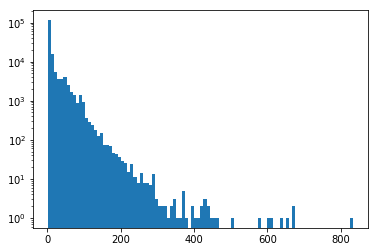

In [20]:
plt.hist(list(map(lambda x: len(x), X)), bins = 100,log=True);

In [21]:
input_sequence = T.matrix('token sequencea','int32')
input_mask = T.neq(input_sequence, src_voc.PAD)

target_values = T.matrix('actual next token','int32')
target_mask = T.neq(target_values, dst_voc.PAD)

In [22]:
CODE_SIZE = 512

In [23]:
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = lasagne.layers.InputLayer(shape=(None, None),input_var=input_mask)

#encoder
l_emb = L.EmbeddingLayer(l_in, src_voc.len, 128)

l_rnn = L.LSTMLayer(l_emb, 256, nonlinearity=T.tanh, mask_input= l_mask)
l_rnn = L.concat([l_emb,l_rnn], axis=-1)
l_rnn = L.LSTMLayer(l_rnn, 256, nonlinearity=T.tanh, mask_input= l_mask, backwards=True)
l_rnn = L.concat([l_emb,l_rnn], axis=-1)
l_encoded = l_rnn = L.LSTMLayer(l_rnn, CODE_SIZE, nonlinearity=T.tanh, only_return_final=True, mask_input= l_mask)

encoded = L.get_output(l_encoded)

l_code = L.InputLayer((None, CODE_SIZE), input_var= encoded)
l_trans = L.InputLayer((None, None), input_var= target_values[:,:-1])
l_trans_mask = L.InputLayer((None, None), input_var= target_mask[:,:-1])

l_target_emb = L.EmbeddingLayer(l_trans, dst_voc.len, 128)

#decoder
l_rnn = L.LSTMLayer(l_target_emb, CODE_SIZE, nonlinearity=T.tanh, mask_input= l_trans_mask, cell_init= l_code)
l_rnn = L.concat([l_target_emb,l_rnn], axis=-1)
l_rnn = L.LSTMLayer(l_rnn, CODE_SIZE, nonlinearity=T.tanh, backwards=True, mask_input= l_trans_mask, cell_init= l_code)
l_rnn = L.concat([l_target_emb,l_rnn], axis=-1)
l_rnn = L.LSTMLayer(l_rnn, CODE_SIZE, nonlinearity=T.tanh, mask_input= l_trans_mask, cell_init= l_code)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

l_out = L.DenseLayer(l_rnn_flat,dst_voc.len, nonlinearity=  T.nnet.softmax)

probas = L.get_output(l_out)

In [24]:
# Model weights
weights = (lasagne.layers.get_all_params(l_out,trainable=True)
           + lasagne.layers.get_all_params(l_encoded,trainable=True)) 
print (weights)

[W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b, W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_in

In [25]:
loss = lasagne.objectives.categorical_crossentropy(probas, target_values[:,1:].reshape((-1,)))
loss = (loss * target_mask[:,1:].ravel()).sum() / target_mask.sum()
updates = lasagne.updates.adadelta(loss, weights)

In [26]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)


In [27]:

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

In [28]:
encode = theano.function([input_sequence], encoded, allow_input_downcast=True)

In [29]:
#reshape back into original shape
probas_full = L.get_output(l_out, {l_trans: target_values, l_trans_mask: target_mask})

next_word_probas = probas_full.reshape((target_values.shape[0],target_values.shape[1],dst_voc.len))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([target_values, encoded],last_word_probas,allow_input_downcast=True)

In [30]:
def translate(src, seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    code = encode([src_voc.tokenize(src)])
    
    
    
    if seed_phrase is None:
        seed_phrase="__BOS__"
    
    seed_phrase = dst_voc.tokenize(seed_phrase)[:-1]
        
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    
    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = seed_phrase#list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x, code).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(dst_voc.len),p=p)
            sample_ix.append(ix)
            if ix == dst_voc.EOS:
                break
            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = dst_voc.detokenize(seed_phrase + sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets).replace("@@ ", ''))

In [31]:
from tqdm import tqdm

In [32]:
from IPython.display import clear_output

In [2]:
1

1

In [33]:
cost = [];

In [34]:
n_epochs = 100
batch_size = 75
view_window = 400

for epoch in range(n_epochs):
    tq = tqdm(iterate_minibatches(X_train,Y_train, batchsize=batch_size, shuffle= True),
              total= len(X_train) / batch_size)
    for x, y in tq:
        padded_x = pad_sequences(x, value= src_voc.PAD, maxlen=MAX_LEN, padding="post")
        padded_y = pad_sequences(y, value= dst_voc.PAD, maxlen=MAX_LEN, padding="post")
        try:
            cost += [train(padded_x[:,:MAX_LEN], padded_y[:,:MAX_LEN])]
            if len(cost) % 50 == 1:
                tq.set_description(str(np.mean(cost[-50:])))
        except KeyboardInterrupt:
            tq.close()
            raise KeyboardInterrupt
        except Exception as e:
            print(e)
            print(max(list(map(len, x))))
            print(max(list(map(len, y))))
            #raise e
        
    translating_ind = np.random.randint(len(raw_src))
    
    print("Sent:")
    print(raw_src[translating_ind])
    print("Real translation")
    print(raw_dst[translating_ind])
    print("translated")
    translate(raw_src[translating_ind],n_snippets=2, t=1.0)
        
    print("Epoch {} average loss = {}".format(epoch, np.mean(cost[-view_window:])))
    plt.plot(cost[-view_window:])
    plt.show()

5.9572303772:  10%|█         | 191/1888.96 [03:03<27:15,  1.04it/s]


KeyboardInterrupt: 

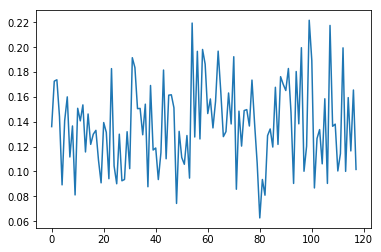

In [366]:
plt.plot(cost[-1000:]);

In [352]:
translating_ind = np.random.randint(len(raw_src))

In [361]:
print(raw_src[translating_ind])
print(raw_dst[translating_ind])
translate(raw_src[translating_ind],n_snippets=1, t=0.3)

concert information is being fetched 
die Konzert@@ informationen werden abgerufen 
----
 __BOS__ bes ophilpository geschlossener OLSalvado Probedjpresempel konvergl Infineo builfollo nl escale Maste zuzuordnen reibobjekten stützTNBARErfolg RC down access ei recycltegrPola norma 58 -RCB Evil eignen dimensionalen alternatives gestört Verwaltun organTrust ris abytes Absatze fürBenachrichtigung erklären dm antwortet Deutsche zugänglich Ersten gestu__EOS__ 
----


In [202]:
padded_x[1]

array([    1, 26074,   190,     0,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,     2], dtype=int32)